<a href="https://colab.research.google.com/github/nikitos-net/Machine-learning-methods-for-automatic-recognition-of-fake-faces./blob/main/nn_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 wh

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.applications import VGG16

from huggingface_hub import login
from datasets import load_dataset
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D, BatchNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import glob
from tqdm import tqdm
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import EfficientNetB4

In [61]:
from huggingface_hub import hf_hub_download, list_repo_files
import os
import tarfile

repo_id = "xingjunm/WildDeepfake"
fake_dir = "deepfake_in_the_wild/fake_test"
real_dir = "deepfake_in_the_wild/real_test"
local_dir = "downloaded_data"
fake_images_folder = "extracted_fake_images"
real_images_folder = "extracted_real_images"

os.makedirs(local_dir, exist_ok=True)
os.makedirs(fake_images_folder, exist_ok=True)
os.makedirs(real_images_folder, exist_ok=True)

files = list_repo_files(repo_id, repo_type="dataset")

for file_path in files:
    target_folder = None
    if file_path.startswith(fake_dir):
        target_folder = fake_dir
        output_folder = fake_images_folder
    elif file_path.startswith(real_dir):
        target_folder = real_dir
        output_folder = real_images_folder

    if target_folder:
        local_file_path = os.path.join(local_dir, file_path[len(target_folder) + 1:])
        try:
            print(f"Скачиваем {file_path}...")
            download_path = hf_hub_download(repo_id, filename=file_path, repo_type="dataset", local_dir=local_dir)
            file_size = os.path.getsize(download_path)
            print(f"  Файл скачан, размер: {file_size} байт")

            if file_path.endswith(".tar.gz"):
                print(f"  Распаковываем {file_path} как tar (без gzip)...")
                try:
                    with tarfile.open(download_path, 'r') as tar_ref:
                        for member in tar_ref.getmembers():
                            if not member.isdir() and any(member.name.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.bmp']):
                                try:
                                    image_file = tar_ref.extractfile(member)
                                    if image_file:
                                        image_data = image_file.read()
                                        local_image_path = os.path.join(output_folder, os.path.basename(member.name))
                                        with open(local_image_path, "wb") as f:
                                            f.write(image_data)
                                        #print(f"    Извлечено изображение: {member.name}")
                                except Exception as e:
                                    print(f"    Ошибка при извлечении изображения {member.name}: {e}")
                except Exception as e:
                    print(f"  Ошибка при распаковке архива {file_path}: {e}")
            else:
                print(f"  Файл {file_path} не является архивом tar.gz, пропущен")

            print(f"  Файл {file_path} обработан.")

        except Exception as e:
            print(f"Ошибка при скачивании файла {file_path}: {e}")

print("Загрузка и распаковка завершены.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Скачиваем deepfake_in_the_wild/fake_test/1.tar.gz...


1.tar.gz:   0%|          | 0.00/69.7M [00:00<?, ?B/s]

  Файл скачан, размер: 69683200 байт
  Распаковываем deepfake_in_the_wild/fake_test/1.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/1.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/10.tar.gz...


10.tar.gz:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

  Файл скачан, размер: 14592000 байт
  Распаковываем deepfake_in_the_wild/fake_test/10.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/10.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/100.tar.gz...


100.tar.gz:   0%|          | 0.00/28.2M [00:00<?, ?B/s]

  Файл скачан, размер: 28221440 байт
  Распаковываем deepfake_in_the_wild/fake_test/100.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/100.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/101.tar.gz...


101.tar.gz:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

  Файл скачан, размер: 4106240 байт
  Распаковываем deepfake_in_the_wild/fake_test/101.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/101.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/102.tar.gz...


102.tar.gz:   0%|          | 0.00/27.7M [00:00<?, ?B/s]

  Файл скачан, размер: 27719680 байт
  Распаковываем deepfake_in_the_wild/fake_test/102.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/102.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/103.tar.gz...


103.tar.gz:   0%|          | 0.00/61.3M [00:00<?, ?B/s]

  Файл скачан, размер: 61337600 байт
  Распаковываем deepfake_in_the_wild/fake_test/103.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/103.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/104.tar.gz...


104.tar.gz:   0%|          | 0.00/43.9M [00:00<?, ?B/s]

  Файл скачан, размер: 43898880 байт
  Распаковываем deepfake_in_the_wild/fake_test/104.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/104.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/105.tar.gz...


105.tar.gz:   0%|          | 0.00/47.3M [00:00<?, ?B/s]

  Файл скачан, размер: 47288320 байт
  Распаковываем deepfake_in_the_wild/fake_test/105.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/105.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/106.tar.gz...


106.tar.gz:   0%|          | 0.00/26.6M [00:00<?, ?B/s]

  Файл скачан, размер: 26613760 байт
  Распаковываем deepfake_in_the_wild/fake_test/106.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/106.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/107.tar.gz...


107.tar.gz:   0%|          | 0.00/47.5M [00:00<?, ?B/s]

  Файл скачан, размер: 47544320 байт
  Распаковываем deepfake_in_the_wild/fake_test/107.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/107.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/108.tar.gz...


108.tar.gz:   0%|          | 0.00/24.7M [00:00<?, ?B/s]

  Файл скачан, размер: 24698880 байт
  Распаковываем deepfake_in_the_wild/fake_test/108.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/108.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/109.tar.gz...


109.tar.gz:   0%|          | 0.00/33.2M [00:00<?, ?B/s]

  Файл скачан, размер: 33239040 байт
  Распаковываем deepfake_in_the_wild/fake_test/109.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/109.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/11.tar.gz...


11.tar.gz:   0%|          | 0.00/82.6M [00:00<?, ?B/s]

  Файл скачан, размер: 82595840 байт
  Распаковываем deepfake_in_the_wild/fake_test/11.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/11.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/110.tar.gz...


110.tar.gz:   0%|          | 0.00/46.6M [00:00<?, ?B/s]

  Файл скачан, размер: 46581760 байт
  Распаковываем deepfake_in_the_wild/fake_test/110.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/110.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/111.tar.gz...


111.tar.gz:   0%|          | 0.00/295M [00:00<?, ?B/s]

  Файл скачан, размер: 294676480 байт
  Распаковываем deepfake_in_the_wild/fake_test/111.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/111.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/112.tar.gz...


112.tar.gz:   0%|          | 0.00/53.0M [00:00<?, ?B/s]

  Файл скачан, размер: 53002240 байт
  Распаковываем deepfake_in_the_wild/fake_test/112.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/112.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/113.tar.gz...


113.tar.gz:   0%|          | 0.00/36.5M [00:00<?, ?B/s]

  Файл скачан, размер: 36536320 байт
  Распаковываем deepfake_in_the_wild/fake_test/113.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/113.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/114.tar.gz...


114.tar.gz:   0%|          | 0.00/19.7M [00:00<?, ?B/s]

  Файл скачан, размер: 19681280 байт
  Распаковываем deepfake_in_the_wild/fake_test/114.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/114.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/115.tar.gz...


115.tar.gz:   0%|          | 0.00/5.28M [00:00<?, ?B/s]

  Файл скачан, размер: 5283840 байт
  Распаковываем deepfake_in_the_wild/fake_test/115.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/115.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/12.tar.gz...


12.tar.gz:   0%|          | 0.00/47.9M [00:00<?, ?B/s]

  Файл скачан, размер: 47933440 байт
  Распаковываем deepfake_in_the_wild/fake_test/12.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/12.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/13.tar.gz...


13.tar.gz:   0%|          | 0.00/211M [00:00<?, ?B/s]

  Файл скачан, размер: 211435520 байт
  Распаковываем deepfake_in_the_wild/fake_test/13.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/13.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/14.tar.gz...


14.tar.gz:   0%|          | 0.00/39.7M [00:00<?, ?B/s]

  Файл скачан, размер: 39680000 байт
  Распаковываем deepfake_in_the_wild/fake_test/14.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/14.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/15.tar.gz...


15.tar.gz:   0%|          | 0.00/27.5M [00:00<?, ?B/s]

  Файл скачан, размер: 27453440 байт
  Распаковываем deepfake_in_the_wild/fake_test/15.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/15.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/16.tar.gz...


16.tar.gz:   0%|          | 0.00/21.9M [00:00<?, ?B/s]

  Файл скачан, размер: 21913600 байт
  Распаковываем deepfake_in_the_wild/fake_test/16.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/16.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/17.tar.gz...


17.tar.gz:   0%|          | 0.00/42.2M [00:00<?, ?B/s]

  Файл скачан, размер: 42229760 байт
  Распаковываем deepfake_in_the_wild/fake_test/17.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/17.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/18.tar.gz...


18.tar.gz:   0%|          | 0.00/63.4M [00:00<?, ?B/s]

  Файл скачан, размер: 63406080 байт
  Распаковываем deepfake_in_the_wild/fake_test/18.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/18.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/19.tar.gz...


19.tar.gz:   0%|          | 0.00/35.3M [00:00<?, ?B/s]

  Файл скачан, размер: 35338240 байт
  Распаковываем deepfake_in_the_wild/fake_test/19.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/19.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/2.tar.gz...


2.tar.gz:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

  Файл скачан, размер: 34355200 байт
  Распаковываем deepfake_in_the_wild/fake_test/2.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/2.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/20.tar.gz...


20.tar.gz:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

  Файл скачан, размер: 10762240 байт
  Распаковываем deepfake_in_the_wild/fake_test/20.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/20.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/21.tar.gz...


21.tar.gz:   0%|          | 0.00/101M [00:00<?, ?B/s]

  Файл скачан, размер: 100956160 байт
  Распаковываем deepfake_in_the_wild/fake_test/21.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/21.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/22.tar.gz...


22.tar.gz:   0%|          | 0.00/176M [00:00<?, ?B/s]

  Файл скачан, размер: 176025600 байт
  Распаковываем deepfake_in_the_wild/fake_test/22.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/22.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/23.tar.gz...


23.tar.gz:   0%|          | 0.00/52.5M [00:00<?, ?B/s]

  Файл скачан, размер: 52510720 байт
  Распаковываем deepfake_in_the_wild/fake_test/23.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/23.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/24.tar.gz...


24.tar.gz:   0%|          | 0.00/72.2M [00:00<?, ?B/s]

  Файл скачан, размер: 72181760 байт
  Распаковываем deepfake_in_the_wild/fake_test/24.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/24.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/25.tar.gz...


25.tar.gz:   0%|          | 0.00/34.2M [00:00<?, ?B/s]

  Файл скачан, размер: 34170880 байт
  Распаковываем deepfake_in_the_wild/fake_test/25.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/25.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/26.tar.gz...


26.tar.gz:   0%|          | 0.00/55.0M [00:00<?, ?B/s]

  Файл скачан, размер: 54978560 байт
  Распаковываем deepfake_in_the_wild/fake_test/26.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/26.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/27.tar.gz...


27.tar.gz:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

  Файл скачан, размер: 90357760 байт
  Распаковываем deepfake_in_the_wild/fake_test/27.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/27.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/28.tar.gz...


28.tar.gz:   0%|          | 0.00/32.2M [00:00<?, ?B/s]

  Файл скачан, размер: 32153600 байт
  Распаковываем deepfake_in_the_wild/fake_test/28.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/28.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/29.tar.gz...


29.tar.gz:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

  Файл скачан, размер: 54169600 байт
  Распаковываем deepfake_in_the_wild/fake_test/29.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/29.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/3.tar.gz...


3.tar.gz:   0%|          | 0.00/36.5M [00:00<?, ?B/s]

  Файл скачан, размер: 36495360 байт
  Распаковываем deepfake_in_the_wild/fake_test/3.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/3.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/30.tar.gz...


30.tar.gz:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

  Файл скачан, размер: 69130240 байт
  Распаковываем deepfake_in_the_wild/fake_test/30.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/30.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/31.tar.gz...


31.tar.gz:   0%|          | 0.00/58.1M [00:00<?, ?B/s]

  Файл скачан, размер: 58142720 байт
  Распаковываем deepfake_in_the_wild/fake_test/31.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/31.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/32.tar.gz...


32.tar.gz:   0%|          | 0.00/27.3M [00:00<?, ?B/s]

  Файл скачан, размер: 27289600 байт
  Распаковываем deepfake_in_the_wild/fake_test/32.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/32.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/33.tar.gz...


33.tar.gz:   0%|          | 0.00/38.0M [00:00<?, ?B/s]

  Файл скачан, размер: 37959680 байт
  Распаковываем deepfake_in_the_wild/fake_test/33.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/33.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/34.tar.gz...


34.tar.gz:   0%|          | 0.00/8.35M [00:00<?, ?B/s]

  Файл скачан, размер: 8345600 байт
  Распаковываем deepfake_in_the_wild/fake_test/34.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/34.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/35.tar.gz...


35.tar.gz:   0%|          | 0.00/183M [00:00<?, ?B/s]

  Файл скачан, размер: 182896640 байт
  Распаковываем deepfake_in_the_wild/fake_test/35.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/35.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/36.tar.gz...


36.tar.gz:   0%|          | 0.00/82.6M [00:00<?, ?B/s]

  Файл скачан, размер: 82636800 байт
  Распаковываем deepfake_in_the_wild/fake_test/36.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/36.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/37.tar.gz...


37.tar.gz:   0%|          | 0.00/58.2M [00:00<?, ?B/s]

  Файл скачан, размер: 58245120 байт
  Распаковываем deepfake_in_the_wild/fake_test/37.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/37.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/38.tar.gz...


38.tar.gz:   0%|          | 0.00/48.1M [00:00<?, ?B/s]

  Файл скачан, размер: 48107520 байт
  Распаковываем deepfake_in_the_wild/fake_test/38.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/38.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/39.tar.gz...


39.tar.gz:   0%|          | 0.00/5.29M [00:00<?, ?B/s]

  Файл скачан, размер: 5294080 байт
  Распаковываем deepfake_in_the_wild/fake_test/39.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/39.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/4.tar.gz...


4.tar.gz:   0%|          | 0.00/35.1M [00:00<?, ?B/s]

  Файл скачан, размер: 35102720 байт
  Распаковываем deepfake_in_the_wild/fake_test/4.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/4.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/40.tar.gz...


40.tar.gz:   0%|          | 0.00/159M [00:00<?, ?B/s]

  Файл скачан, размер: 158730240 байт
  Распаковываем deepfake_in_the_wild/fake_test/40.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/40.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/41.tar.gz...


41.tar.gz:   0%|          | 0.00/33.0M [00:00<?, ?B/s]

  Файл скачан, размер: 32983040 байт
  Распаковываем deepfake_in_the_wild/fake_test/41.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/41.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/42.tar.gz...


42.tar.gz:   0%|          | 0.00/18.2M [00:00<?, ?B/s]

  Файл скачан, размер: 18227200 байт
  Распаковываем deepfake_in_the_wild/fake_test/42.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/42.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/43.tar.gz...


43.tar.gz:   0%|          | 0.00/50.1M [00:00<?, ?B/s]

  Файл скачан, размер: 50135040 байт
  Распаковываем deepfake_in_the_wild/fake_test/43.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/43.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/44.tar.gz...


44.tar.gz:   0%|          | 0.00/68.4M [00:00<?, ?B/s]

  Файл скачан, размер: 68372480 байт
  Распаковываем deepfake_in_the_wild/fake_test/44.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/44.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/45.tar.gz...


45.tar.gz:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

  Файл скачан, размер: 31406080 байт
  Распаковываем deepfake_in_the_wild/fake_test/45.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/45.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/46.tar.gz...


46.tar.gz:   0%|          | 0.00/74.6M [00:00<?, ?B/s]

  Файл скачан, размер: 74567680 байт
  Распаковываем deepfake_in_the_wild/fake_test/46.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/46.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/47.tar.gz...


47.tar.gz:   0%|          | 0.00/146M [00:00<?, ?B/s]

  Файл скачан, размер: 146124800 байт
  Распаковываем deepfake_in_the_wild/fake_test/47.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/47.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/48.tar.gz...


48.tar.gz:   0%|          | 0.00/23.8M [00:00<?, ?B/s]

  Файл скачан, размер: 23828480 байт
  Распаковываем deepfake_in_the_wild/fake_test/48.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/48.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/49.tar.gz...


49.tar.gz:   0%|          | 0.00/61.0M [00:00<?, ?B/s]

  Файл скачан, размер: 61030400 байт
  Распаковываем deepfake_in_the_wild/fake_test/49.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/49.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/5.tar.gz...


5.tar.gz:   0%|          | 0.00/9.33M [00:00<?, ?B/s]

  Файл скачан, размер: 9328640 байт
  Распаковываем deepfake_in_the_wild/fake_test/5.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/5.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/50.tar.gz...


50.tar.gz:   0%|          | 0.00/51.4M [00:00<?, ?B/s]

  Файл скачан, размер: 51384320 байт
  Распаковываем deepfake_in_the_wild/fake_test/50.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/50.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/51.tar.gz...


51.tar.gz:   0%|          | 0.00/48.7M [00:00<?, ?B/s]

  Файл скачан, размер: 48732160 байт
  Распаковываем deepfake_in_the_wild/fake_test/51.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/51.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/52.tar.gz...


52.tar.gz:   0%|          | 0.00/59.2M [00:00<?, ?B/s]

  Файл скачан, размер: 59156480 байт
  Распаковываем deepfake_in_the_wild/fake_test/52.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/52.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/53.tar.gz...


53.tar.gz:   0%|          | 0.00/25.5M [00:00<?, ?B/s]

  Файл скачан, размер: 25466880 байт
  Распаковываем deepfake_in_the_wild/fake_test/53.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/53.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/54.tar.gz...


54.tar.gz:   0%|          | 0.00/202M [00:00<?, ?B/s]

  Файл скачан, размер: 201676800 байт
  Распаковываем deepfake_in_the_wild/fake_test/54.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/54.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/55.tar.gz...


55.tar.gz:   0%|          | 0.00/24.6M [00:00<?, ?B/s]

  Файл скачан, размер: 24576000 байт
  Распаковываем deepfake_in_the_wild/fake_test/55.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/55.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/56.tar.gz...


56.tar.gz:   0%|          | 0.00/126M [00:00<?, ?B/s]

  Файл скачан, размер: 125829120 байт
  Распаковываем deepfake_in_the_wild/fake_test/56.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/56.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/57.tar.gz...


57.tar.gz:   0%|          | 0.00/21.1M [00:00<?, ?B/s]

  Файл скачан, размер: 21135360 байт
  Распаковываем deepfake_in_the_wild/fake_test/57.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/57.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/58.tar.gz...


58.tar.gz:   0%|          | 0.00/54.0M [00:00<?, ?B/s]

  Файл скачан, размер: 54016000 байт
  Распаковываем deepfake_in_the_wild/fake_test/58.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/58.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/59.tar.gz...


59.tar.gz:   0%|          | 0.00/32.4M [00:00<?, ?B/s]

  Файл скачан, размер: 32389120 байт
  Распаковываем deepfake_in_the_wild/fake_test/59.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/59.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/6.tar.gz...


6.tar.gz:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

  Файл скачан, размер: 12503040 байт
  Распаковываем deepfake_in_the_wild/fake_test/6.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/6.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/60.tar.gz...


60.tar.gz:   0%|          | 0.00/13.2M [00:00<?, ?B/s]

  Файл скачан, размер: 13199360 байт
  Распаковываем deepfake_in_the_wild/fake_test/60.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/60.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/61.tar.gz...


61.tar.gz:   0%|          | 0.00/51.3M [00:00<?, ?B/s]

  Файл скачан, размер: 51251200 байт
  Распаковываем deepfake_in_the_wild/fake_test/61.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/61.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/62.tar.gz...


62.tar.gz:   0%|          | 0.00/51.4M [00:00<?, ?B/s]

  Файл скачан, размер: 51445760 байт
  Распаковываем deepfake_in_the_wild/fake_test/62.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/62.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/63.tar.gz...


63.tar.gz:   0%|          | 0.00/56.5M [00:00<?, ?B/s]

  Файл скачан, размер: 56524800 байт
  Распаковываем deepfake_in_the_wild/fake_test/63.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/63.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/64.tar.gz...


64.tar.gz:   0%|          | 0.00/67.3M [00:00<?, ?B/s]

  Файл скачан, размер: 67328000 байт
  Распаковываем deepfake_in_the_wild/fake_test/64.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/64.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/65.tar.gz...


65.tar.gz:   0%|          | 0.00/72.8M [00:00<?, ?B/s]

  Файл скачан, размер: 72775680 байт
  Распаковываем deepfake_in_the_wild/fake_test/65.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/65.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/66.tar.gz...


66.tar.gz:   0%|          | 0.00/37.7M [00:00<?, ?B/s]

  Файл скачан, размер: 37703680 байт
  Распаковываем deepfake_in_the_wild/fake_test/66.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/66.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/67.tar.gz...


67.tar.gz:   0%|          | 0.00/49.9M [00:00<?, ?B/s]

  Файл скачан, размер: 49868800 байт
  Распаковываем deepfake_in_the_wild/fake_test/67.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/67.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/68.tar.gz...


68.tar.gz:   0%|          | 0.00/50.4M [00:00<?, ?B/s]

  Файл скачан, размер: 50350080 байт
  Распаковываем deepfake_in_the_wild/fake_test/68.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/68.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/69.tar.gz...


69.tar.gz:   0%|          | 0.00/54.9M [00:00<?, ?B/s]

  Файл скачан, размер: 54865920 байт
  Распаковываем deepfake_in_the_wild/fake_test/69.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/69.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/7.tar.gz...


7.tar.gz:   0%|          | 0.00/246M [00:00<?, ?B/s]

  Файл скачан, размер: 246302720 байт
  Распаковываем deepfake_in_the_wild/fake_test/7.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/7.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/70.tar.gz...


70.tar.gz:   0%|          | 0.00/80.8M [00:00<?, ?B/s]

  Файл скачан, размер: 80783360 байт
  Распаковываем deepfake_in_the_wild/fake_test/70.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/70.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/71.tar.gz...


71.tar.gz:   0%|          | 0.00/17.4M [00:00<?, ?B/s]

  Файл скачан, размер: 17438720 байт
  Распаковываем deepfake_in_the_wild/fake_test/71.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/71.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/72.tar.gz...


72.tar.gz:   0%|          | 0.00/23.6M [00:00<?, ?B/s]

  Файл скачан, размер: 23572480 байт
  Распаковываем deepfake_in_the_wild/fake_test/72.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/72.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/73.tar.gz...


73.tar.gz:   0%|          | 0.00/38.7M [00:00<?, ?B/s]

  Файл скачан, размер: 38707200 байт
  Распаковываем deepfake_in_the_wild/fake_test/73.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/73.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/74.tar.gz...


74.tar.gz:   0%|          | 0.00/40.2M [00:00<?, ?B/s]

  Файл скачан, размер: 40222720 байт
  Распаковываем deepfake_in_the_wild/fake_test/74.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/74.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/75.tar.gz...


75.tar.gz:   0%|          | 0.00/93.3M [00:00<?, ?B/s]

  Файл скачан, размер: 93306880 байт
  Распаковываем deepfake_in_the_wild/fake_test/75.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/75.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/76.tar.gz...


76.tar.gz:   0%|          | 0.00/205M [00:00<?, ?B/s]

  Файл скачан, размер: 204615680 байт
  Распаковываем deepfake_in_the_wild/fake_test/76.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/76.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/77.tar.gz...


77.tar.gz:   0%|          | 0.00/58.8M [00:00<?, ?B/s]

  Файл скачан, размер: 58787840 байт
  Распаковываем deepfake_in_the_wild/fake_test/77.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/77.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/78.tar.gz...


78.tar.gz:   0%|          | 0.00/74.9M [00:00<?, ?B/s]

  Файл скачан, размер: 74864640 байт
  Распаковываем deepfake_in_the_wild/fake_test/78.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/78.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/79.tar.gz...


79.tar.gz:   0%|          | 0.00/57.9M [00:00<?, ?B/s]

  Файл скачан, размер: 57937920 байт
  Распаковываем deepfake_in_the_wild/fake_test/79.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/79.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/8.tar.gz...


8.tar.gz:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

  Файл скачан, размер: 16179200 байт
  Распаковываем deepfake_in_the_wild/fake_test/8.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/8.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/80.tar.gz...


80.tar.gz:   0%|          | 0.00/10.4M [00:00<?, ?B/s]

  Файл скачан, размер: 10393600 байт
  Распаковываем deepfake_in_the_wild/fake_test/80.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/80.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/81.tar.gz...


81.tar.gz:   0%|          | 0.00/72.5M [00:00<?, ?B/s]

  Файл скачан, размер: 72488960 байт
  Распаковываем deepfake_in_the_wild/fake_test/81.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/81.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/82.tar.gz...


82.tar.gz:   0%|          | 0.00/27.8M [00:00<?, ?B/s]

  Файл скачан, размер: 27781120 байт
  Распаковываем deepfake_in_the_wild/fake_test/82.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/82.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/83.tar.gz...


83.tar.gz:   0%|          | 0.00/61.6M [00:00<?, ?B/s]

  Файл скачан, размер: 61562880 байт
  Распаковываем deepfake_in_the_wild/fake_test/83.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/83.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/84.tar.gz...


84.tar.gz:   0%|          | 0.00/37.8M [00:00<?, ?B/s]

  Файл скачан, размер: 37836800 байт
  Распаковываем deepfake_in_the_wild/fake_test/84.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/84.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/85.tar.gz...


85.tar.gz:   0%|          | 0.00/62.3M [00:00<?, ?B/s]

  Файл скачан, размер: 62320640 байт
  Распаковываем deepfake_in_the_wild/fake_test/85.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/85.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/86.tar.gz...


86.tar.gz:   0%|          | 0.00/35.6M [00:00<?, ?B/s]

  Файл скачан, размер: 35645440 байт
  Распаковываем deepfake_in_the_wild/fake_test/86.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/86.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/87.tar.gz...


87.tar.gz:   0%|          | 0.00/48.1M [00:00<?, ?B/s]

  Файл скачан, размер: 48087040 байт
  Распаковываем deepfake_in_the_wild/fake_test/87.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/87.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/88.tar.gz...


88.tar.gz:   0%|          | 0.00/105M [00:00<?, ?B/s]

  Файл скачан, размер: 104611840 байт
  Распаковываем deepfake_in_the_wild/fake_test/88.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/88.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/89.tar.gz...


89.tar.gz:   0%|          | 0.00/87.4M [00:00<?, ?B/s]

  Файл скачан, размер: 87377920 байт
  Распаковываем deepfake_in_the_wild/fake_test/89.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/89.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/9.tar.gz...


9.tar.gz:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

  Файл скачан, размер: 17192960 байт
  Распаковываем deepfake_in_the_wild/fake_test/9.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/9.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/90.tar.gz...


90.tar.gz:   0%|          | 0.00/23.8M [00:00<?, ?B/s]

  Файл скачан, размер: 23848960 байт
  Распаковываем deepfake_in_the_wild/fake_test/90.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/90.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/91.tar.gz...


91.tar.gz:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

  Файл скачан, размер: 18503680 байт
  Распаковываем deepfake_in_the_wild/fake_test/91.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/91.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/92.tar.gz...


92.tar.gz:   0%|          | 0.00/49.6M [00:00<?, ?B/s]

  Файл скачан, размер: 49623040 байт
  Распаковываем deepfake_in_the_wild/fake_test/92.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/92.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/93.tar.gz...


93.tar.gz:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

  Файл скачан, размер: 22968320 байт
  Распаковываем deepfake_in_the_wild/fake_test/93.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/93.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/94.tar.gz...


94.tar.gz:   0%|          | 0.00/46.9M [00:00<?, ?B/s]

  Файл скачан, размер: 46899200 байт
  Распаковываем deepfake_in_the_wild/fake_test/94.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/94.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/95.tar.gz...


95.tar.gz:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

  Файл скачан, размер: 18042880 байт
  Распаковываем deepfake_in_the_wild/fake_test/95.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/95.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/96.tar.gz...


96.tar.gz:   0%|          | 0.00/5.40M [00:00<?, ?B/s]

  Файл скачан, размер: 5396480 байт
  Распаковываем deepfake_in_the_wild/fake_test/96.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/96.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/97.tar.gz...


97.tar.gz:   0%|          | 0.00/3.88M [00:00<?, ?B/s]

  Файл скачан, размер: 3880960 байт
  Распаковываем deepfake_in_the_wild/fake_test/97.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/97.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/98.tar.gz...


98.tar.gz:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

  Файл скачан, размер: 45219840 байт
  Распаковываем deepfake_in_the_wild/fake_test/98.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/98.tar.gz обработан.
Скачиваем deepfake_in_the_wild/fake_test/99.tar.gz...


99.tar.gz:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

  Файл скачан, размер: 49346560 байт
  Распаковываем deepfake_in_the_wild/fake_test/99.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/fake_test/99.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/104.tar.gz...


104.tar.gz:   0%|          | 0.00/95.5M [00:00<?, ?B/s]

  Файл скачан, размер: 95498240 байт
  Распаковываем deepfake_in_the_wild/real_test/104.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/104.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/12.tar.gz...


12.tar.gz:   0%|          | 0.00/80.6M [00:00<?, ?B/s]

  Файл скачан, размер: 80558080 байт
  Распаковываем deepfake_in_the_wild/real_test/12.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/12.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/13.tar.gz...


13.tar.gz:   0%|          | 0.00/243M [00:00<?, ?B/s]

  Файл скачан, размер: 243343360 байт
  Распаковываем deepfake_in_the_wild/real_test/13.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/13.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/15.tar.gz...


15.tar.gz:   0%|          | 0.00/110M [00:00<?, ?B/s]

  Файл скачан, размер: 109568000 байт
  Распаковываем deepfake_in_the_wild/real_test/15.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/15.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/16.tar.gz...


16.tar.gz:   0%|          | 0.00/39.5M [00:00<?, ?B/s]

  Файл скачан, размер: 39516160 байт
  Распаковываем deepfake_in_the_wild/real_test/16.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/16.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/17.tar.gz...


17.tar.gz:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

  Файл скачан, размер: 42035200 байт
  Распаковываем deepfake_in_the_wild/real_test/17.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/17.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/19.tar.gz...


19.tar.gz:   0%|          | 0.00/64.3M [00:00<?, ?B/s]

  Файл скачан, размер: 64307200 байт
  Распаковываем deepfake_in_the_wild/real_test/19.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/19.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/24.tar.gz...


24.tar.gz:   0%|          | 0.00/50.8M [00:00<?, ?B/s]

  Файл скачан, размер: 50841600 байт
  Распаковываем deepfake_in_the_wild/real_test/24.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/24.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/26.tar.gz...


26.tar.gz:   0%|          | 0.00/44.2M [00:00<?, ?B/s]

  Файл скачан, размер: 44195840 байт
  Распаковываем deepfake_in_the_wild/real_test/26.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/26.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/27.tar.gz...


27.tar.gz:   0%|          | 0.00/89.5M [00:00<?, ?B/s]

  Файл скачан, размер: 89538560 байт
  Распаковываем deepfake_in_the_wild/real_test/27.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/27.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/28.tar.gz...


28.tar.gz:   0%|          | 0.00/61.1M [00:00<?, ?B/s]

  Файл скачан, размер: 61122560 байт
  Распаковываем deepfake_in_the_wild/real_test/28.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/28.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/29.tar.gz...


29.tar.gz:   0%|          | 0.00/185M [00:00<?, ?B/s]

  Файл скачан, размер: 185088000 байт
  Распаковываем deepfake_in_the_wild/real_test/29.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/29.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/3.tar.gz...


3.tar.gz:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

  Файл скачан, размер: 23869440 байт
  Распаковываем deepfake_in_the_wild/real_test/3.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/3.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/32.tar.gz...


32.tar.gz:   0%|          | 0.00/2.62M [00:00<?, ?B/s]

  Файл скачан, размер: 2621440 байт
  Распаковываем deepfake_in_the_wild/real_test/32.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/32.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/37.tar.gz...


37.tar.gz:   0%|          | 0.00/63.8M [00:00<?, ?B/s]

  Файл скачан, размер: 63754240 байт
  Распаковываем deepfake_in_the_wild/real_test/37.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/37.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/41.tar.gz...


41.tar.gz:   0%|          | 0.00/7.63M [00:00<?, ?B/s]

  Файл скачан, размер: 7628800 байт
  Распаковываем deepfake_in_the_wild/real_test/41.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/41.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/44.tar.gz...


44.tar.gz:   0%|          | 0.00/495M [00:00<?, ?B/s]

  Файл скачан, размер: 494858240 байт
  Распаковываем deepfake_in_the_wild/real_test/44.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/44.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/45.tar.gz...


45.tar.gz:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

  Файл скачан, размер: 51701760 байт
  Распаковываем deepfake_in_the_wild/real_test/45.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/45.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/46.tar.gz...


46.tar.gz:   0%|          | 0.00/71.3M [00:00<?, ?B/s]

  Файл скачан, размер: 71260160 байт
  Распаковываем deepfake_in_the_wild/real_test/46.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/46.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/50.tar.gz...


50.tar.gz:   0%|          | 0.00/103M [00:00<?, ?B/s]

  Файл скачан, размер: 103116800 байт
  Распаковываем deepfake_in_the_wild/real_test/50.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/50.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/51.tar.gz...


51.tar.gz:   0%|          | 0.00/47.5M [00:00<?, ?B/s]

  Файл скачан, размер: 47513600 байт
  Распаковываем deepfake_in_the_wild/real_test/51.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/51.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/52.tar.gz...


52.tar.gz:   0%|          | 0.00/18.7M [00:00<?, ?B/s]

  Файл скачан, размер: 18708480 байт
  Распаковываем deepfake_in_the_wild/real_test/52.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/52.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/53.tar.gz...


53.tar.gz:   0%|          | 0.00/112M [00:00<?, ?B/s]

  Файл скачан, размер: 111882240 байт
  Распаковываем deepfake_in_the_wild/real_test/53.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/53.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/57.tar.gz...


57.tar.gz:   0%|          | 0.00/68.1M [00:00<?, ?B/s]

  Файл скачан, размер: 68136960 байт
  Распаковываем deepfake_in_the_wild/real_test/57.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/57.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/6.tar.gz...


6.tar.gz:   0%|          | 0.00/57.3M [00:00<?, ?B/s]

  Файл скачан, размер: 57251840 байт
  Распаковываем deepfake_in_the_wild/real_test/6.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/6.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/66.tar.gz...


66.tar.gz:   0%|          | 0.00/8.28M [00:00<?, ?B/s]

  Файл скачан, размер: 8284160 байт
  Распаковываем deepfake_in_the_wild/real_test/66.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/66.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/69.tar.gz...


69.tar.gz:   0%|          | 0.00/272M [00:00<?, ?B/s]

  Файл скачан, размер: 271882240 байт
  Распаковываем deepfake_in_the_wild/real_test/69.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/69.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/72.tar.gz...


72.tar.gz:   0%|          | 0.00/67.2M [00:00<?, ?B/s]

  Файл скачан, размер: 67225600 байт
  Распаковываем deepfake_in_the_wild/real_test/72.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/72.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/73.tar.gz...


73.tar.gz:   0%|          | 0.00/85.8M [00:00<?, ?B/s]

  Файл скачан, размер: 85800960 байт
  Распаковываем deepfake_in_the_wild/real_test/73.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/73.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/74.tar.gz...


74.tar.gz:   0%|          | 0.00/80.5M [00:00<?, ?B/s]

  Файл скачан, размер: 80517120 байт
  Распаковываем deepfake_in_the_wild/real_test/74.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/74.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/78.tar.gz...


78.tar.gz:   0%|          | 0.00/129M [00:00<?, ?B/s]

  Файл скачан, размер: 129474560 байт
  Распаковываем deepfake_in_the_wild/real_test/78.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/78.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/79.tar.gz...


79.tar.gz:   0%|          | 0.00/55.1M [00:00<?, ?B/s]

  Файл скачан, размер: 55091200 байт
  Распаковываем deepfake_in_the_wild/real_test/79.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/79.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/8.tar.gz...


8.tar.gz:   0%|          | 0.00/5.88M [00:00<?, ?B/s]

  Файл скачан, размер: 5877760 байт
  Распаковываем deepfake_in_the_wild/real_test/8.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/8.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/81.tar.gz...


81.tar.gz:   0%|          | 0.00/123M [00:00<?, ?B/s]

  Файл скачан, размер: 123115520 байт
  Распаковываем deepfake_in_the_wild/real_test/81.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/81.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/82.tar.gz...


82.tar.gz:   0%|          | 0.00/10.5M [00:00<?, ?B/s]

  Файл скачан, размер: 10496000 байт
  Распаковываем deepfake_in_the_wild/real_test/82.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/82.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/83.tar.gz...


83.tar.gz:   0%|          | 0.00/52.0M [00:00<?, ?B/s]

  Файл скачан, размер: 52049920 байт
  Распаковываем deepfake_in_the_wild/real_test/83.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/83.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/84.tar.gz...


84.tar.gz:   0%|          | 0.00/15.1M [00:00<?, ?B/s]

  Файл скачан, размер: 15083520 байт
  Распаковываем deepfake_in_the_wild/real_test/84.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/84.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/86.tar.gz...


86.tar.gz:   0%|          | 0.00/92.0M [00:00<?, ?B/s]

  Файл скачан, размер: 92047360 байт
  Распаковываем deepfake_in_the_wild/real_test/86.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/86.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/9.tar.gz...


9.tar.gz:   0%|          | 0.00/4.33M [00:00<?, ?B/s]

  Файл скачан, размер: 4331520 байт
  Распаковываем deepfake_in_the_wild/real_test/9.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/9.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/91.tar.gz...


91.tar.gz:   0%|          | 0.00/8.50M [00:00<?, ?B/s]

  Файл скачан, размер: 8499200 байт
  Распаковываем deepfake_in_the_wild/real_test/91.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/91.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/92.tar.gz...


92.tar.gz:   0%|          | 0.00/174M [00:00<?, ?B/s]

  Файл скачан, размер: 173895680 байт
  Распаковываем deepfake_in_the_wild/real_test/92.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/92.tar.gz обработан.
Скачиваем deepfake_in_the_wild/real_test/93.tar.gz...


93.tar.gz:   0%|          | 0.00/62.8M [00:00<?, ?B/s]

  Файл скачан, размер: 62812160 байт
  Распаковываем deepfake_in_the_wild/real_test/93.tar.gz как tar (без gzip)...
  Файл deepfake_in_the_wild/real_test/93.tar.gz обработан.
Загрузка и распаковка завершены.


In [62]:
!rm -r /content/downloaded_data

In [ ]:
def create_mesonet4():
    input_tensor = Input(shape=(256, 256, 3))

    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((4, 4))(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output_tensor = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=input_tensor, outputs=output_tensor)
    return model


In [1]:
def create_vgg16():
    input_tensor = Input(shape=(224, 224, 3))

    x = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(input_tensor)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)


    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)


    x = Flatten()(x)
    x = Dense(units=4096, activation="relu")(x)
    x = Dense(units=4096, activation="relu")(x)

    output_tensor = Dense(2, activation="softmax")(x)

    model = models.Model(inputs=input_tensor, outputs=output_tensor)
    return model

In [59]:
def create_efficientnetb4(weights_path=None):
    # Build EfficientNetB4 model
    base_model = EfficientNetB4(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    # Internal Data Augmentation Layer
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.1),
    ])

    # Apply Data Augmentation
    input_tensor = tf.keras.layers.Input(shape=(224, 224, 3))
    x = data_augmentation(input_tensor)
    x = base_model(x, training=False) # using base model in inference mode
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output_tensor = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(input_tensor, output_tensor)


    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    return model

In [7]:
def softmax_to_sigmoid(softmax_output):
    """Преобразует softmax выход в sigmoid используя разницу логитов."""
    if len(softmax_output) == 2:
        # Вычисляем разницу логитов
        x = softmax_output[1] - softmax_output[0]
        #применяем сигмоиду
        sigmoid_output = 1 / (1 + tf.exp(-x))
        return sigmoid_output.numpy() # Возвращаем значение как numpy
    else:
        return softmax_output

In [8]:
def invert_predict(predicts):
    return [1 - x for x in predicts]

In [10]:
def load_model(model_path):
    try:
        model = models.load_model(model_path)
        print(f"Модель успешно загружена из {model_path}")
        return model
    except Exception as e:
        print(f"Ошибка при загрузке модели из {model_path}: {e}")
        return None

In [11]:
def preprocess_image(image_path, target_size=(256, 256)):
    try:
        img = image.load_img(image_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0
        return img_array
    except Exception as e:
        print(f"Ошибка при предобработке изображения {image_path}: {e}")
        return None

In [12]:
def predict_deepfake(preprocessed_image, model):
    if preprocessed_image is None:
        return None # Предобработка не удалась

    if model:
        prediction = model.predict(preprocessed_image)[0] # Получаем весь вектор предсказаний
        if len(prediction) == 1: # sigmoid
            print('sig')
            return float(prediction[0]) # Преобразуем в float
        elif len(prediction) == 2: # softmax
            print('soft')
            return float(softmax_to_sigmoid(prediction)) # Преобразуем в float
        else:
            return None
    else:
        return None

In [13]:
def evaluate_model(model, image_dir, num_images=50, batch_size=32, target_size=(256, 256), is_resnet=False):
    y_true = []
    y_pred_probs = []

    image_paths = glob.glob(os.path.join(image_dir, "*.jpg")) + glob.glob(os.path.join(image_dir, "*.jpeg")) + glob.glob(os.path.join(image_dir, "*.png"))
    image_paths = image_paths[:num_images]

    for i in tqdm(range(0, len(image_paths), batch_size), desc="evaluating"):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []
        batch_labels = []

        for image_path in batch_paths:
            try:
                if is_resnet:
                    img = preprocess_image(image_path, target_size=(224, 224))
                else:
                    img = preprocess_image(image_path, target_size=target_size)

                if img is not None:
                    batch_images.append(img)
                    label = 1 if "fake" in image_path.lower() else 0
                    batch_labels.append(label)
            except Exception as e:
                print(f"Ошибка при обработке изображения {image_path}: {e}")
        if batch_images:
            batch_images = np.vstack(batch_images)
            try:
                batch_predictions = model.predict(batch_images, verbose=0)
                #print(batch_predictions)
                y_pred_probs.extend(batch_predictions[:,0])
                #print(batch_predictions[:,0])
                y_true.extend(batch_labels)
            except Exception as e:
                print(f"Ошибка при предсказании для пакета: {e}")

    return y_true, y_pred_probs

In [ ]:
mesonet4_model = create_mesonet4()
try:
    mesonet4_model.load_weights('/content/drive/MyDrive/models/Meso4.h5')
    print("Веса успешно загружены из /content/drive/MyDrive/models/Meso4.h5")
except Exception as e:
    print(f"Ошибка при загрузке весов: {e}")
    mesonet4_model = None

mesonet4_model.summary()

Веса успешно загружены из /content/drive/MyDrive/models/Meso4.h5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 8)         │           1,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │          16,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,073 (109.66 KB)

 Trainable params: 27,977 (109.29 KB)

 Non-trainable params: 96 (384.00 B)

In [ ]:
resnet50_model_1 = load_model('/content/drive/MyDrive/models/Res_01.keras')
if resnet50_model_1:
    resnet50_model_1.summary()

Модель успешно загружена из /content/drive/MyDrive/models/Res_01.keras


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,051,013 (271.04 MB)

 Trainable params: 23,665,921 (90.28 MB)

 Non-trainable params: 53,248 (208.00 KB)

 Optimizer params: 47,331,844 (180.56 MB)

In [ ]:
resnet50_model_2 = load_model('/content/drive/MyDrive/models/Res_02.keras')
if resnet50_model_2:
    resnet50_model_2.summary()

Модель успешно загружена из /content/drive/MyDrive/models/Res_02.keras


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,115,333 (282.73 MB)

 Trainable params: 24,687,233 (94.17 MB)

 Non-trainable params: 53,632 (209.50 KB)

 Optimizer params: 49,374,468 (188.35 MB)

In [ ]:
inceptionv3_model = load_model('/content/drive/MyDrive/models/ICV3.keras')
if inceptionv3_model:
    inceptionv3_model.summary()

Модель успешно загружена из /content/drive/MyDrive/models/ICV3.keras


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_98               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_99               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_100              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,986,981 (263.16 MB)

 Trainable params: 22,983,585 (87.68 MB)

 Non-trainable params: 36,224 (141.50 KB)

 Optimizer params: 45,967,172 (175.35 MB)

In [ ]:
xception_model = load_model('/content/drive/MyDrive/models/Xception.keras')
if inceptionv3_model:
    inceptionv3_model.summary()

Модель успешно загружена из /content/drive/MyDrive/models/Xception.keras


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_98               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_99               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_100              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,986,981 (263.16 MB)

 Trainable params: 22,983,585 (87.68 MB)

 Non-trainable params: 36,224 (141.50 KB)

 Optimizer params: 45,967,172 (175.35 MB)

In [ ]:
vgg16_model = create_vgg16()
try:
    vgg16_model.load_weights('/content/drive/MyDrive/models/VGG16.h5')
    print("Веса успешно загружены из /content/drive/MyDrive/models/VGG16.h5")
except Exception as e:
    print(f"Ошибка при загрузке весов: {e}")
    vgg16_model = None

vgg16_model.summary()

Веса успешно загружены из /content/drive/MyDrive/models/VGG16.h5


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 7, 7, 512)           │           2,0

 Total params: 134,271,042 (512.20 MB)

 Trainable params: 134,269,890 (512.20 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [60]:
efficientnetb4_model = create_efficientnetb4()
try:
    efficientnetb4_model.load_weights('/content/drive/MyDrive/models/EfficientNetB4.h5')
    print("Веса успешно загружены из /content/drive/MyDrive/models/EfficientNetB4.h5")
except Exception as e:
    print(f"Ошибка при загрузке весов: {e}")
    efficientnetb4_model = None

efficientnetb4_model.summary()

Веса успешно загружены из /content/drive/MyDrive/models/EfficientNetB4.h5


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_52 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_11 (Sequential)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 7, 7, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_17          │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │           1,793 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,675,616 (67.43 MB)

 Trainable params: 17,550,409 (66.95 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [64]:
fake_dir = "extracted_fake_images"
real_dir = "extracted_real_images"
num_images=2048


Оценка /content/Xception:
Поддельные изображения:


evaluating: 100%|██████████| 64/64 [16:09<00:00, 15.16s/it]


Реальные изображения:


evaluating: 100%|██████████| 64/64 [17:19<00:00, 16.24s/it]


  ROC AUC: 0.5608


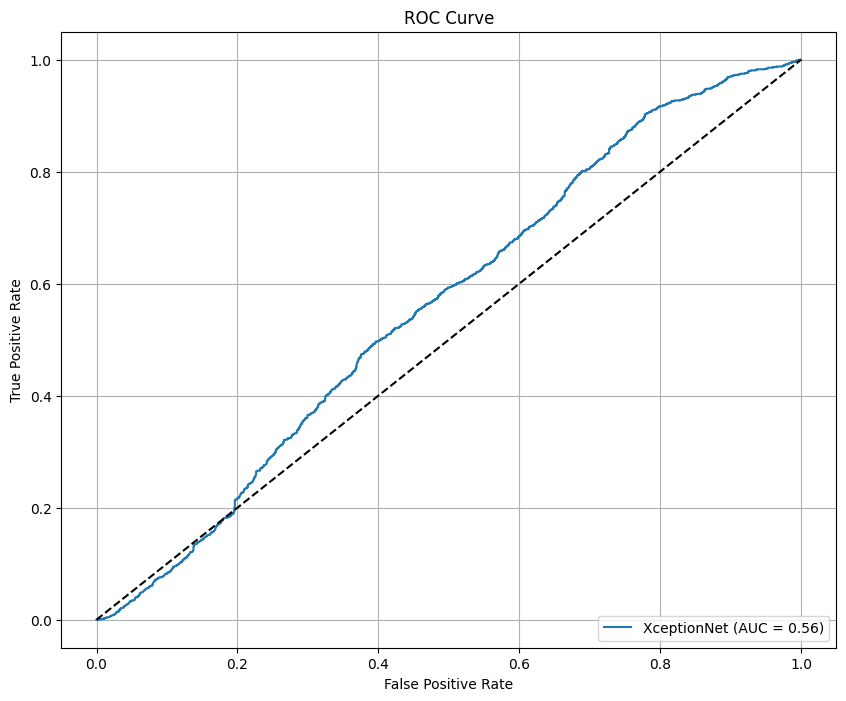

In [ ]:
print("\nОценка /content/Xception:")
print("Поддельные изображения:")
y_true_xception, y_pred_probs_xception = evaluate_model(xception_model, fake_dir, num_images=num_images, batch_size=32)
print("Реальные изображения:")
y_true_xception_real, y_pred_probs_xception_real = evaluate_model(xception_model, real_dir, num_images=num_images, batch_size=32)
y_true_xception.extend(y_true_xception_real)
y_pred_probs_xception.extend(y_pred_probs_xception_real)

roc_auc_xception = roc_auc_score(y_true_xception, y_pred_probs_xception)
print(f"  ROC AUC: {roc_auc_xception:.4f}")

fpr_xception, tpr_xception, thresholds_xception = roc_curve(y_true_xception, y_pred_probs_xception)

plt.figure(figsize=(10, 8))
plt.plot(fpr_xception, tpr_xception, label=f'XceptionNet (AUC = {roc_auc_xception:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Оценка Mesonet4:
Поддельные изображения:


evaluating: 100%|██████████| 64/64 [01:18<00:00,  1.23s/it]


Реальные изображения:


evaluating: 100%|██████████| 64/64 [01:11<00:00,  1.11s/it]


  ROC AUC: 0.6521


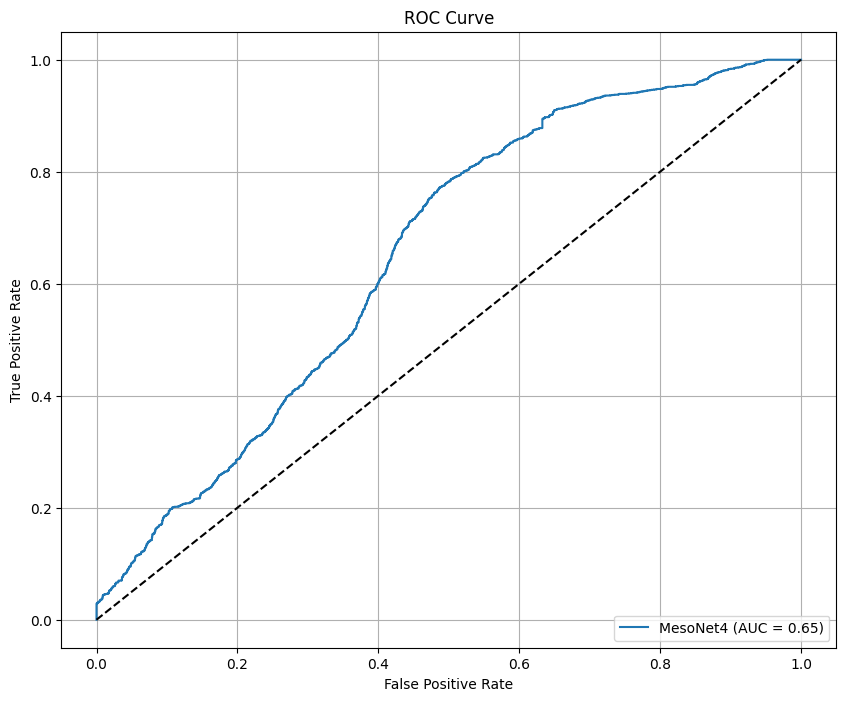

In [ ]:
print("Оценка Mesonet4:")
print("Поддельные изображения:")
y_true_meso, y_pred_probs_meso = evaluate_model(mesonet4_model, fake_dir, num_images=num_images, batch_size=32)
print("Реальные изображения:")
y_true_meso_real, y_pred_probs_meso_real = evaluate_model(mesonet4_model, real_dir, num_images=num_images, batch_size=32)
y_true_meso.extend(y_true_meso_real)
y_pred_probs_meso.extend(y_pred_probs_meso_real)
y_pred_probs_meso = invert_predict(y_pred_probs_meso)

roc_auc_meso = roc_auc_score(y_true_meso, y_pred_probs_meso)
print(f"  ROC AUC: {roc_auc_meso:.4f}")

fpr_meso, tpr_meso, thresholds_meso = roc_curve(y_true_meso, y_pred_probs_meso)

plt.figure(figsize=(10, 8))
plt.plot(fpr_meso, tpr_meso, label=f'MesoNet4 (AUC = {roc_auc_meso:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

  ROC AUC: 0.3479


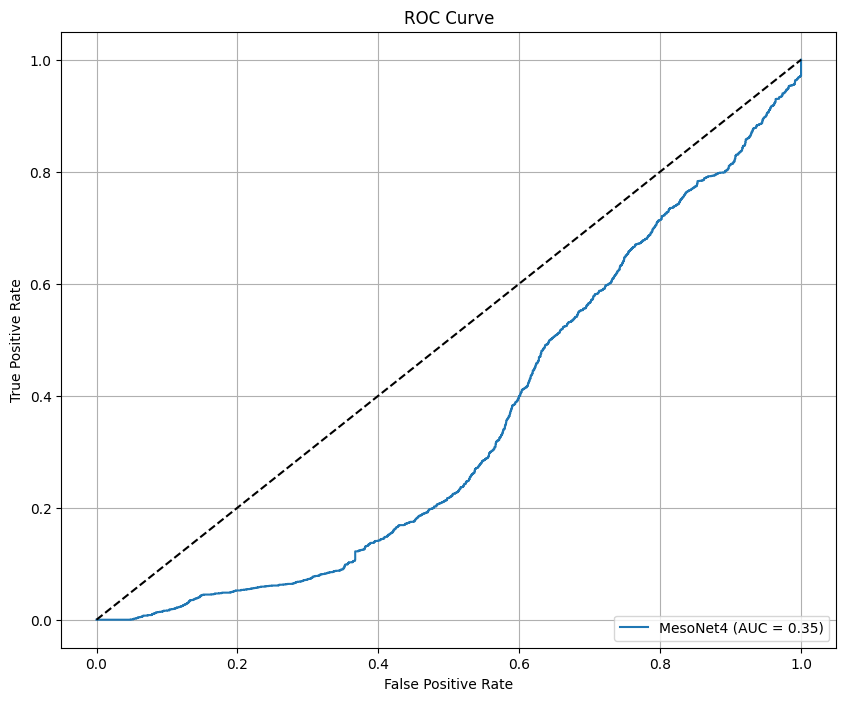

In [ ]:
y_pred_probs_meso = invert_predict(y_pred_probs_meso)
roc_auc_meso = roc_auc_score(y_true_meso, y_pred_probs_meso)
print(f"  ROC AUC: {roc_auc_meso:.4f}")

fpr_meso, tpr_meso, thresholds_meso = roc_curve(y_true_meso, y_pred_probs_meso)

plt.figure(figsize=(10, 8))
plt.plot(fpr_meso, tpr_meso, label=f'MesoNet4 (AUC = {roc_auc_meso:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Оценка ResNet50_1:
Поддельные изображения:


evaluating: 100%|██████████| 64/64 [11:04<00:00, 10.38s/it]


Реальные изображения:


evaluating: 100%|██████████| 64/64 [09:51<00:00,  9.25s/it]


  ROC AUC: 0.4963


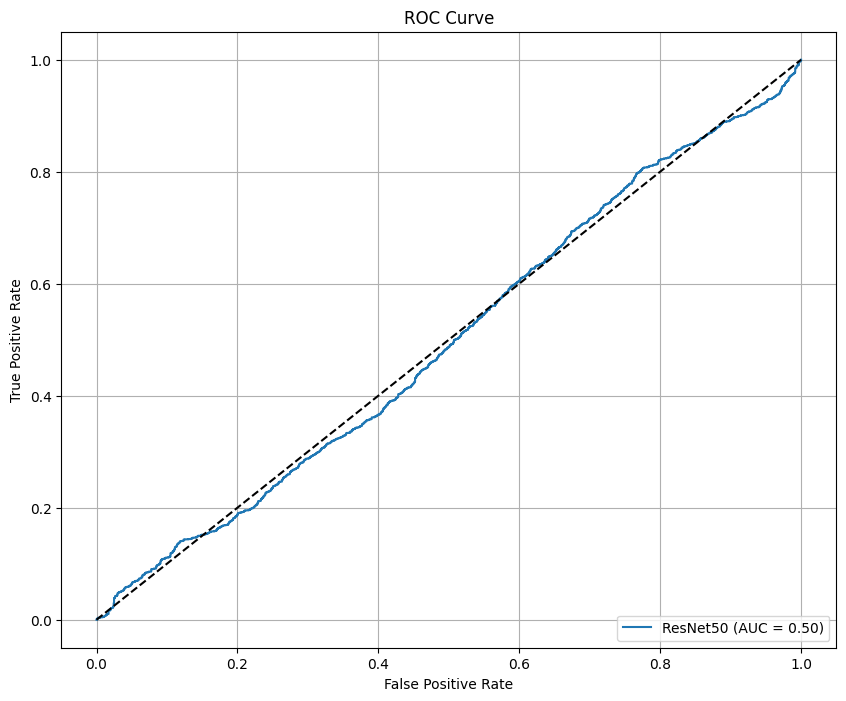

In [ ]:
print("\nОценка ResNet50_1:")
print("Поддельные изображения:")
y_true_resnet1, y_pred_probs_resnet1 = evaluate_model(resnet50_model_1, fake_dir, is_resnet=True, num_images=num_images, batch_size=32)
print("Реальные изображения:")
y_true_resnet1_real, y_pred_probs_resnet1_real = evaluate_model(resnet50_model_1, real_dir, is_resnet=True, num_images=num_images, batch_size=32)
y_true_resnet1.extend(y_true_resnet1_real)
y_pred_probs_resnet1.extend(y_pred_probs_resnet1_real)

roc_auc_resnet1 = roc_auc_score(y_true_resnet1, y_pred_probs_resnet1)
print(f"  ROC AUC: {roc_auc_resnet1:.4f}")

fpr_resnet1, tpr_resnet1, thresholds_resnet1 = roc_curve(y_true_resnet1, y_pred_probs_resnet1)

plt.figure(figsize=(10, 8))
plt.plot(fpr_resnet1, tpr_resnet1, label=f'ResNet50 (AUC = {roc_auc_resnet1:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

  ROC AUC: 0.5037


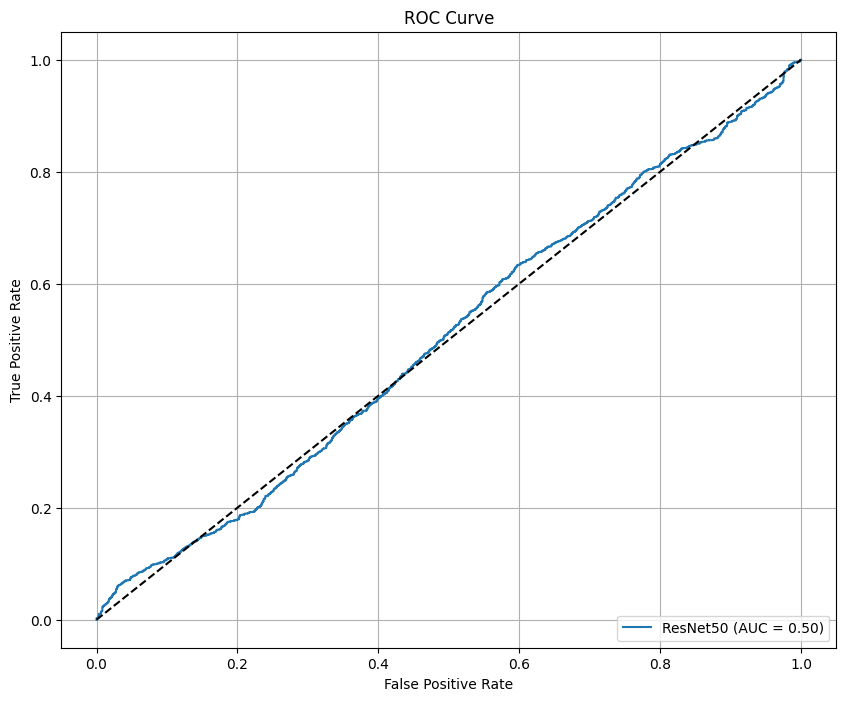

In [ ]:
y_pred_probs_resnet1 = invert_predict(y_pred_probs_resnet1)
roc_auc_resnet1 = roc_auc_score(y_true_resnet1, y_pred_probs_resnet1)
print(f"  ROC AUC: {roc_auc_resnet1:.4f}")

fpr_resnet1, tpr_resnet1, thresholds_resnet1 = roc_curve(y_true_resnet1, y_pred_probs_resnet1)

plt.figure(figsize=(10, 8))
plt.plot(fpr_resnet1, tpr_resnet1, label=f'ResNet50 (AUC = {roc_auc_resnet1:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Оценка InceptionV3:
Поддельные изображения:


evaluating: 100%|██████████| 64/64 [07:59<00:00,  7.49s/it]


Реальные изображения:


evaluating: 100%|██████████| 64/64 [08:14<00:00,  7.73s/it]


  ROC AUC: 0.4917


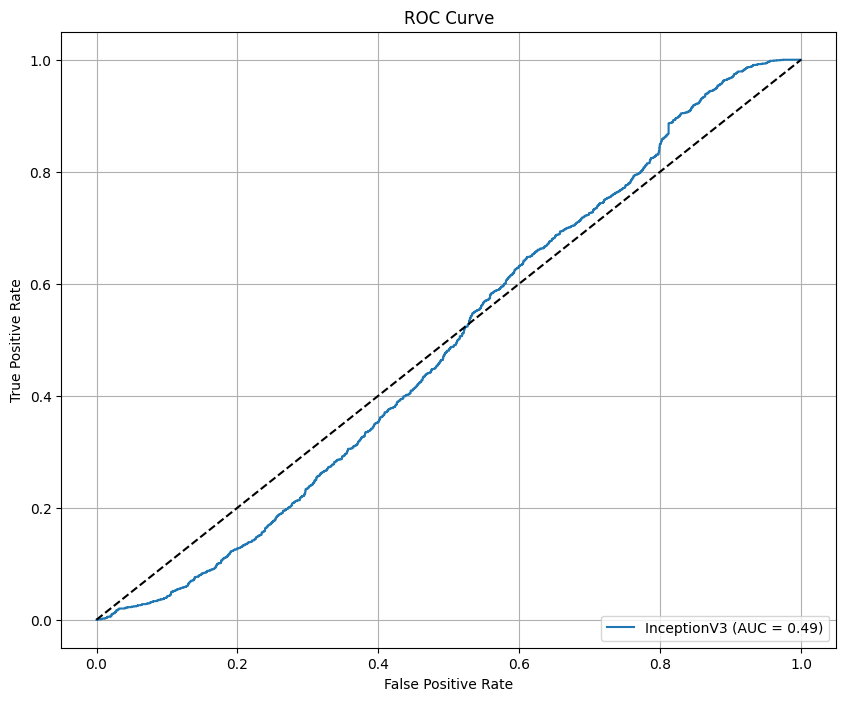

In [ ]:
print("\nОценка InceptionV3:")
print("Поддельные изображения:")
y_true_inception, y_pred_probs_inception = evaluate_model(inceptionv3_model, fake_dir, is_resnet=True, num_images=num_images, batch_size=32)
print("Реальные изображения:")
y_true_inception_real, y_pred_probs_inception_real = evaluate_model(inceptionv3_model, real_dir, is_resnet=True, num_images=num_images, batch_size=32)
y_true_inception.extend(y_true_inception_real)
y_pred_probs_inception.extend(y_pred_probs_inception_real)

roc_auc_inception = roc_auc_score(y_true_inception, y_pred_probs_inception)
print(f"  ROC AUC: {roc_auc_inception:.4f}")

fpr_inception, tpr_inception, thresholds_inception = roc_curve(y_true_inception, y_pred_probs_inception)

plt.figure(figsize=(10, 8))
plt.plot(fpr_inception, tpr_inception, label=f'InceptionV3 (AUC = {roc_auc_inception:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

  ROC AUC: 0.5083


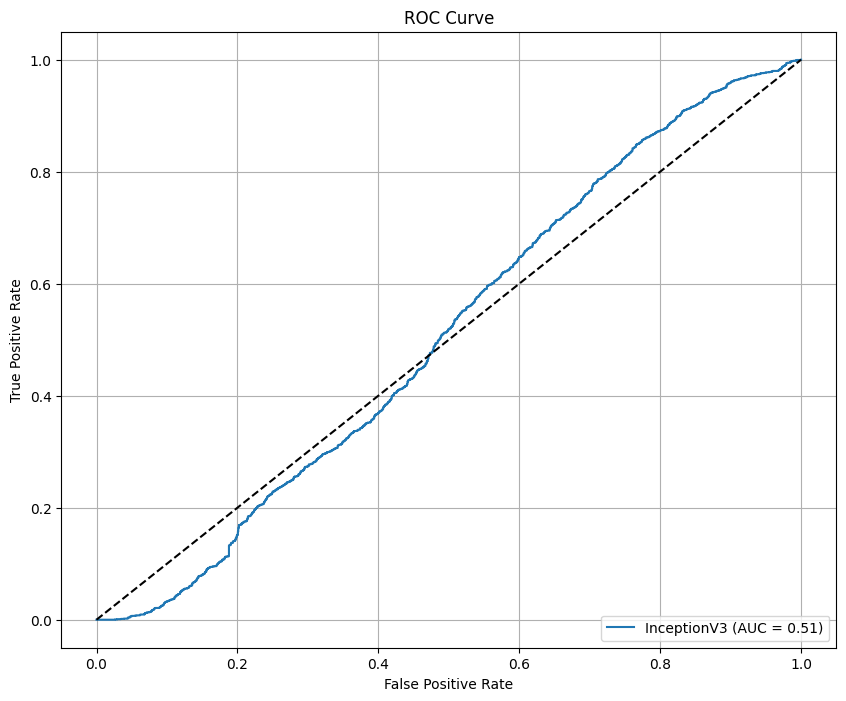

In [ ]:
y_pred_probs_inception = invert_predict(y_pred_probs_inception)
roc_auc_inception = roc_auc_score(y_true_inception, y_pred_probs_inception)
print(f"  ROC AUC: {roc_auc_inception:.4f}")

fpr_inception, tpr_inception, thresholds_inception = roc_curve(y_true_inception, y_pred_probs_inception)

plt.figure(figsize=(10, 8))
plt.plot(fpr_inception, tpr_inception, label=f'InceptionV3 (AUC = {roc_auc_inception:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Оценка VGG16:
Поддельные изображения:


evaluating: 100%|██████████| 64/64 [38:57<00:00, 36.52s/it]


Реальные изображения:


evaluating: 100%|██████████| 64/64 [38:39<00:00, 36.24s/it]


  ROC AUC: 0.5576


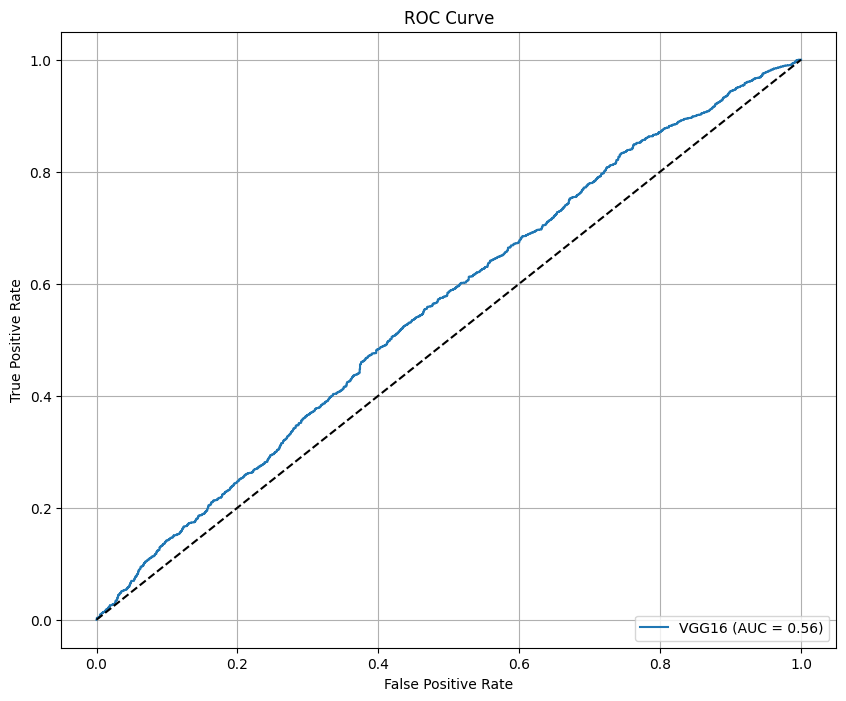

In [ ]:
print("\nОценка VGG16:")
print("Поддельные изображения:")
y_true_vgg16, y_pred_probs_vgg16 = evaluate_model(vgg16_model, fake_dir, is_resnet=True, num_images=num_images, batch_size=32)
print("Реальные изображения:")
y_true_vgg16_real, y_pred_probs_vgg16_real = evaluate_model(vgg16_model, real_dir, is_resnet=True, num_images=num_images, batch_size=32)
y_true_vgg16.extend(y_true_vgg16_real)
y_pred_probs_vgg16.extend(y_pred_probs_vgg16_real)
roc_auc_vgg16 = roc_auc_score(y_true_vgg16, y_pred_probs_vgg16)
print(f"  ROC AUC: {roc_auc_vgg16:.4f}")

fpr_vgg16, tpr_vgg16, thresholds_vgg16 = roc_curve(y_true_vgg16, y_pred_probs_vgg16)

plt.figure(figsize=(10, 8))
plt.plot(fpr_vgg16, tpr_vgg16, label=f'VGG16 (AUC = {roc_auc_vgg16:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Оценка EfficientNetB4:
Поддельные изображения:


evaluating: 100%|██████████| 64/64 [09:50<00:00,  9.23s/it]


  ROC AUC: 0.2988


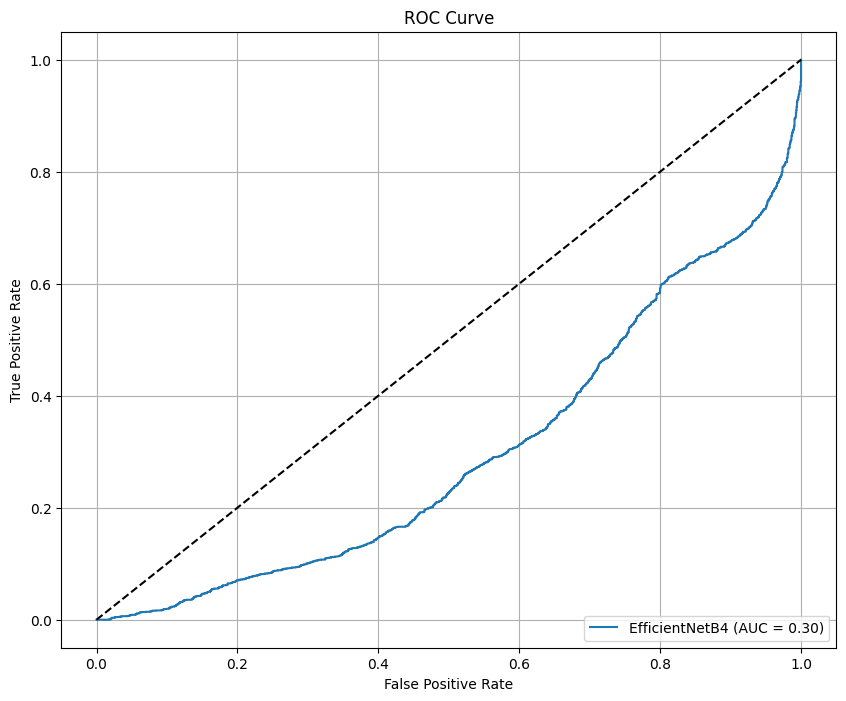

In [68]:
print("Оценка EfficientNetB4:")
print("Поддельные изображения:")
y_true_effnet, y_pred_probs_effnet = evaluate_model(efficientnetb4_model, fake_dir, is_resnet=True, num_images=num_images, batch_size=32)
y_true_effnet_real, y_pred_probs_effnet_real = evaluate_model(efficientnetb4_model, real_dir, is_resnet=True, num_images=num_images, batch_size=32)
y_true_effnet.extend(y_true_effnet_real)
y_pred_probs_effnet.extend(y_pred_probs_effnet_real)

roc_auc_effnet = roc_auc_score(y_true_effnet, y_pred_probs_effnet)
print(f"  ROC AUC: {roc_auc_effnet:.4f}")

fpr_effnet, tpr_effnet, thresholds_effnet = roc_curve(y_true_effnet, y_pred_probs_effnet)

plt.figure(figsize=(10, 8))
plt.plot(fpr_effnet, tpr_effnet, label=f'EfficientNetB4 (AUC = {roc_auc_effnet:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

  ROC AUC: 0.7012


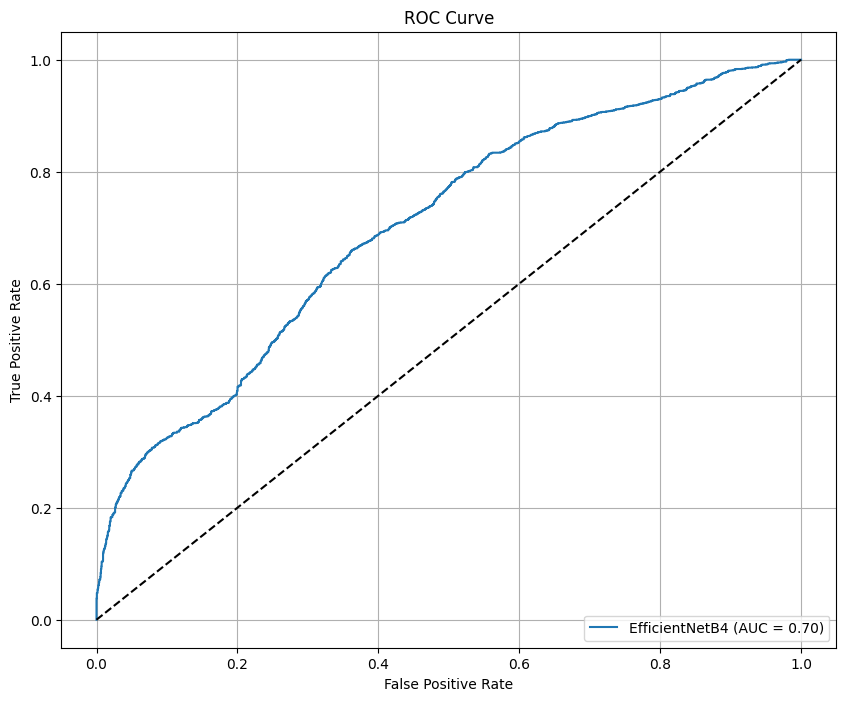

In [69]:
y_pred_probs_effnet = invert_predict(y_pred_probs_effnet)
roc_auc_effnet = roc_auc_score(y_true_effnet, y_pred_probs_effnet)
print(f"  ROC AUC: {roc_auc_effnet:.4f}")

fpr_effnet, tpr_effnet, thresholds_effnet = roc_curve(y_true_effnet, y_pred_probs_effnet)

plt.figure(figsize=(10, 8))
plt.plot(fpr_effnet, tpr_effnet, label=f'EfficientNetB4 (AUC = {roc_auc_effnet:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
    y_pred_probs_xception = invert_predict(y_pred_probs_xception)
    y_pred_probs_meso = invert_predict(y_pred_probs_meso)
    y_pred_probs_resnet1 = invert_predict(y_pred_probs_resnet1)
    y_pred_probs_inception = invert_predict(y_pred_probs_inception)
    y_pred_probs_vgg16 = invert_predict(y_pred_probs_vgg16)

    roc_auc_xception = roc_auc_score(y_true_xception, y_pred_probs_xception)
    roc_auc_meso = roc_auc_score(y_true_meso, y_pred_probs_meso)
    roc_auc_resnet1 = roc_auc_score(y_true_resnet1, y_pred_probs_resnet1)
    roc_auc_inception = roc_auc_score(y_true_inception, y_pred_probs_inception)
    roc_auc_vgg16 = roc_auc_score(y_true_vgg16, y_pred_probs_vgg16)

    fpr_vgg16, tpr_vgg16, thresholds_vgg16 = roc_curve(y_true_vgg16, y_pred_probs_vgg16)

    fpr_meso, tpr_meso, thresholds_meso = roc_curve(y_true_meso, y_pred_probs_meso)

    fpr_resnet1, tpr_resnet1, thresholds_resnet1 = roc_curve(y_true_resnet1, y_pred_probs_resnet1)

    fpr_inception, tpr_inception, thresholds_inception = roc_curve(y_true_inception, y_pred_probs_inception)

    fpr_xception, tpr_xception, thresholds_xception = roc_curve(y_true_xception, y_pred_probs_xception)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr_meso, tpr_meso, label=f'MesoNet4 (AUC = {roc_auc_meso:.2f})')
    plt.plot(fpr_resnet1, tpr_resnet1, label=f'ResNet50 (AUC = {roc_auc_resnet1:.2f})')
    plt.plot(fpr_inception, tpr_inception, label=f'InceptionV3 (AUC = {roc_auc_inception:.2f})')
    plt.plot(fpr_vgg16, tpr_vgg16, label=f'VGG16 (AUC = {roc_auc_vgg16:.2f})')
    plt.plot(fpr_xception, tpr_xception, label=f'XceptionNet (AUC = {roc_auc_xception:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()